In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

# **Import necessary libraries**


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# **Load the dataset**

In [ ]:
file_path = '/content/128V_10PPS_Processed_C105_disc.csv'
data = pd.read_csv(file_path)



# **Step 1: Drop unnecessary columns and normalize features and labels**




In [ ]:
data.drop(columns=['Unnamed: 0'], inplace=True)
features = data.drop(columns=['Severity']).values

# Normalize the features using MinMaxScaler
scaler_features = MinMaxScaler()
normalized_features = scaler_features.fit_transform(features)

# Normalize the label ('Severity')
scaler_labels = MinMaxScaler()
normalized_labels = scaler_labels.fit_transform(data[['Severity']].values)


## **Step 2: Update the clustering features and apply K-Means clustering**

In [ ]:

clustering_features = normalized_features[:, [5, 6, 7, 4]]
kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(clustering_features)

# Assign priority levels to each cluster
cluster_priority = {}
for cluster in range(3):
    cluster_data = data[data['Cluster'] == cluster]
    avg_rate = cluster_data['Rate'].mean()
    cluster_priority[cluster] = 'High' if avg_rate > np.percentile(data['Rate'], 70) else 'Low'

# Define processing frequencies
processing_frequency = {'High': 1, 'Low': 3}



# **Step 3: Split the dataset among multiple RSUs**

In [ ]:
def split_data(data, num_clients=3):
    rsu_datasets = []
    split_size = len(data) // num_clients
    for i in range(num_clients):
        rsu_data = data.iloc[i * split_size: (i + 1) * split_size]
        rsu_datasets.append(rsu_data)
    return rsu_datasets

num_clients = 3
rsu_datasets = split_data(data, num_clients=num_clients)



#**Step 4: Define the model**

In [ ]:

class RSUModel(nn.Module):
    def __init__(self):
        super(RSUModel, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        return self.fc4(x)


#**Step 5: Train each RSU locally**

In [ ]:
def train_local_model(rsu_data, model, epochs=5, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    features = rsu_data[['Rate', 'Sender Stopping Distance', 'Receiver Stopping Distance', 'Actual Distance']].values
    labels = scaler_labels.transform(rsu_data[['Severity']].values)

    features_tensor = torch.tensor(features, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.float32)

    dataset = TensorDataset(features_tensor, labels_tensor)
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

    for epoch in range(epochs):
        for features_batch, labels_batch in dataloader:
            optimizer.zero_grad()
            predictions = model(features_batch)
            loss = criterion(predictions, labels_batch)
            loss.backward()
            optimizer.step()

    return model.state_dict(), loss.item()


#**Step 6: Federated averaging:**




In [ ]:
def federated_averaging(models):
    global_model_state = models[0].copy()
    for key in global_model_state:
        for model_state in models[1:]:
            global_model_state[key] += model_state[key]
        global_model_state[key] /= len(models)
    return global_model_state


## **Step 7: Simulate federated learning with processing frequency based on priority**

In [ ]:
global_model = RSUModel()
rsu_models = [RSUModel() for _ in range(num_clients)]

print("\nFederated Learning Simulation with Multiple RSUs and Processing Frequency")
for cycle in range(10):  # Simulate 10 communication rounds
    print(f"\nCycle {cycle + 1}:")
    local_models = []
    for i, rsu_data in enumerate(rsu_datasets):
        cluster_id = rsu_data['Cluster'].iloc[0]
        priority = cluster_priority[cluster_id]

        # Check if the RSU should be processed in this cycle based on its priority
        if (cycle + 1) % processing_frequency[priority] == 0:
            print(f"  Training RSU {i + 1} (Cluster: {cluster_id}, Priority: {priority})")
            model_state, loss = train_local_model(rsu_data, rsu_models[i], epochs=5)
            local_models.append(model_state)
            print(f"    - RSU {i + 1} Local Training Loss: {loss:.4f}")

    # Perform federated averaging only if models were trained in this cycle
    if local_models:
        global_model_state = federated_averaging(local_models)
        global_model.load_state_dict(global_model_state)

        # Update local models with the new global model
        for rsu_model in rsu_models:
            rsu_model.load_state_dict(global_model_state)

print("\nFederated Learning Completed. Global Model is updated.")


Federated Learning Simulation with Multiple RSUs and Processing Frequency

Cycle 1:
  Training RSU 1 (Cluster: 2, Priority: High)
    - RSU 1 Local Training Loss: 0.3963

Cycle 2:
  Training RSU 1 (Cluster: 2, Priority: High)
    - RSU 1 Local Training Loss: 0.0628

Cycle 3:
  Training RSU 1 (Cluster: 2, Priority: High)
    - RSU 1 Local Training Loss: 0.0499
  Training RSU 2 (Cluster: 1, Priority: Low)
    - RSU 2 Local Training Loss: 0.1119
  Training RSU 3 (Cluster: 1, Priority: Low)
    - RSU 3 Local Training Loss: 0.0610

Cycle 4:
  Training RSU 1 (Cluster: 2, Priority: High)
    - RSU 1 Local Training Loss: 0.1920

Cycle 5:
  Training RSU 1 (Cluster: 2, Priority: High)
    - RSU 1 Local Training Loss: 0.3608

Cycle 6:
  Training RSU 1 (Cluster: 2, Priority: High)
    - RSU 1 Local Training Loss: 0.0548
  Training RSU 2 (Cluster: 1, Priority: Low)
    - RSU 2 Local Training Loss: 0.2095
  Training RSU 3 (Cluster: 1, Priority: Low)
    - RSU 3 Local Training Loss: 0.1382

Cycle 7:

#using spark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import MinMaxScaler as SparkMinMaxScaler
from pyspark.ml.clustering import KMeans as SparkKMeans
from pyspark.sql.functions import col
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt


#**Initialize Spark session**

In [ ]:
spark = SparkSession.builder.appName("FederatedLearning").getOrCreate()

In [ ]:
from pyspark.ml.feature import VectorAssembler, MinMaxScaler

# Load the dataset into a Spark DataFrame
file_path = '/content/drive/MyDrive/128V_10PPS_Processed_C105_disc.csv'
data = spark.read.csv(file_path, header=True, inferSchema=True)

# Drop unnecessary column
data = data.drop("Unnamed: 0")

# Separate features and label
features = data.drop("Severity")
label = data.select("Severity")

#**Normalize the features using Spark's MinMaxScaler**

In [ ]:
assembler = VectorAssembler(inputCols=features.columns, outputCol="features")
data = assembler.transform(data)

# Normalize the features
scaler_features = MinMaxScaler(inputCol="features", outputCol="normalized_features")
scaler_features_model = scaler_features.fit(data)
data = scaler_features_model.transform(data)

# Convert 'Severity' to a vector column
label_assembler = VectorAssembler(inputCols=["Severity"], outputCol="label_vector")
data = label_assembler.transform(data)

# Normalize the label (Severity)
scaler_labels = MinMaxScaler(inputCol="label_vector", outputCol="normalized_severity")
scaler_labels_model = scaler_labels.fit(data)
data = scaler_labels_model.transform(data)

# **Apply KMeans clustering**

In [ ]:
kmeans = SparkKMeans(k=3, seed=42, featuresCol="normalized_features", predictionCol="Cluster")
model = kmeans.fit(data)
data = model.transform(data)

# **Visualize cluster distribution**


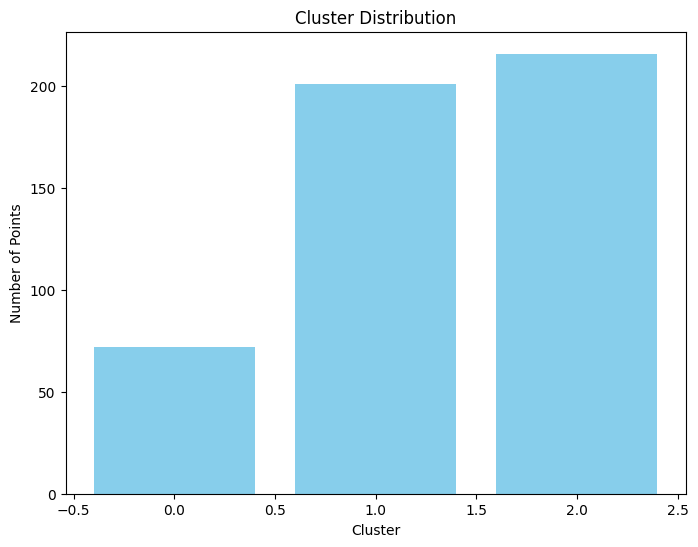

In [ ]:
cluster_counts = data.groupBy("Cluster").count().collect()
clusters, counts = zip(*[(row["Cluster"], row["count"]) for row in cluster_counts])

plt.figure(figsize=(8, 6))
plt.bar(clusters, counts, color='skyblue')
plt.title("Cluster Distribution")
plt.xlabel("Cluster")
plt.ylabel("Number of Points")
plt.show()

# **Assign priority levels to each cluster**


In [ ]:
cluster_priority = {}
for cluster in range(3):
    cluster_data = data.filter(col("Cluster") == cluster)
    avg_rate = cluster_data.select("Rate").agg({"Rate": "avg"}).collect()[0][0]
    percentile_70 = np.percentile(
        [row["Rate"] for row in cluster_data.select("Rate").collect()], 70
    )
    cluster_priority[cluster] = "High" if avg_rate > percentile_70 else "Low"


# Define processing frequencies
processing_frequency = {"High": 1, "Low": 3}



# **Split the dataset among multiple RSUs**

In [ ]:
def split_data_by_cluster(data, num_clients=3):
    clusters = data.select("Cluster").distinct().collect()
    cluster_datasets = {}

    for cluster in clusters:
        cluster_id = cluster["Cluster"]
        cluster_datasets[cluster_id] = data.filter(col("Cluster") == cluster_id)

    rsu_datasets = []
    for i in range(num_clients):
        client_data = None
        for cluster_id in cluster_datasets:
            cluster_data = cluster_datasets[cluster_id].sample(
                withReplacement=False, fraction=1.0 / num_clients
            )
            if client_data is None:
                client_data = cluster_data
            else:
                client_data = client_data.union(cluster_data)
        rsu_datasets.append(client_data)

    return rsu_datasets

num_clients = 3
rsu_datasets = split_data_by_cluster(data, num_clients=num_clients)

# **Define RSU model**

In [ ]:
class RSUModel(nn.Module):
    def __init__(self):
        super(RSUModel, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        return self.fc4(x)


# **Train RSU locally**

In [ ]:
def train_local_model(rsu_data, model, epochs=5, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Convert Spark DataFrame to pandas for features
    features = rsu_data.select(
        "Rate", "Sender Stopping Distance", "Receiver Stopping Distance", "Actual Distance"
    ).toPandas().values

    labels = rsu_data.select("normalized_severity").rdd.flatMap(lambda x: x).collect()
    labels = np.array([label[0] for label in labels]).astype(np.float32).reshape(-1, 1)

    features_tensor = torch.tensor(features, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.float32)

    dataset = TensorDataset(features_tensor, labels_tensor)
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

    training_losses = []
    for epoch in range(epochs):
        for features_batch, labels_batch in dataloader:
            optimizer.zero_grad()
            predictions = model(features_batch)
            loss = criterion(predictions, labels_batch)
            loss.backward()
            optimizer.step()
        training_losses.append(loss.item())

    return model.state_dict(), training_losses

# **Federated averaging**

In [ ]:
def federated_averaging(models):
    global_model_state = models[0].copy()
    for key in global_model_state:
        for model_state in models[1:]:
            global_model_state[key] += model_state[key]
        global_model_state[key] /= len(models)
    return global_model_state


# **Federated Learning Simulation with Visualizations**

In [ ]:
global_model = RSUModel()
rsu_models = [RSUModel() for _ in range(num_clients)]

all_cycle_losses = []

for cycle in range(10):  # Simulate 10 communication rounds
    print(f"\nCycle {cycle + 1}:")
    local_models = []
    cycle_losses = []

    for i, rsu_data in enumerate(rsu_datasets):
        clusters_in_rsu = rsu_data.select("Cluster").distinct().collect()
        for cluster_row in clusters_in_rsu:
            cluster_id = cluster_row["Cluster"]
            priority = cluster_priority[cluster_id]

            # Train only if the cluster's priority matches the cycle frequency
            if (cycle + 1) % processing_frequency[priority] == 0:
                print(f"  Training RSU {i + 1} (Cluster: {cluster_id}, Priority: {priority})")
                model_state, losses = train_local_model(rsu_data, rsu_models[i], epochs=5)
                local_models.append(model_state)
                cycle_losses.append(np.mean(losses))
                print(f"    - RSU {i + 1} Local Training Loss: {losses[-1]:.4f}")

    all_cycle_losses.append(np.mean(cycle_losses) if cycle_losses else None)

    if local_models:
        global_model_state = federated_averaging(local_models)
        global_model.load_state_dict(global_model_state)

        for rsu_model in rsu_models:
            rsu_model.load_state_dict(global_model_state)

print("\nFederated Learning Completed. Global Model is updated.")



Cycle 1:
  Training RSU 1 (Cluster: 2, Priority: High)
    - RSU 1 Local Training Loss: 0.5364
  Training RSU 2 (Cluster: 2, Priority: High)
    - RSU 2 Local Training Loss: 0.0679
  Training RSU 3 (Cluster: 2, Priority: High)
    - RSU 3 Local Training Loss: 2.0328

Cycle 2:
  Training RSU 1 (Cluster: 2, Priority: High)
    - RSU 1 Local Training Loss: 0.0474
  Training RSU 2 (Cluster: 2, Priority: High)
    - RSU 2 Local Training Loss: 0.0636
  Training RSU 3 (Cluster: 2, Priority: High)
    - RSU 3 Local Training Loss: 0.0706

Cycle 3:
  Training RSU 1 (Cluster: 1, Priority: Low)
    - RSU 1 Local Training Loss: 0.0990
  Training RSU 1 (Cluster: 2, Priority: High)
    - RSU 1 Local Training Loss: 0.0655
  Training RSU 1 (Cluster: 0, Priority: Low)
    - RSU 1 Local Training Loss: 0.1426
  Training RSU 2 (Cluster: 1, Priority: Low)
    - RSU 2 Local Training Loss: 0.0927
  Training RSU 2 (Cluster: 2, Priority: High)
    - RSU 2 Local Training Loss: 0.0984
  Training RSU 2 (Cluster: 

# **Plot the average loss per communication cycle**


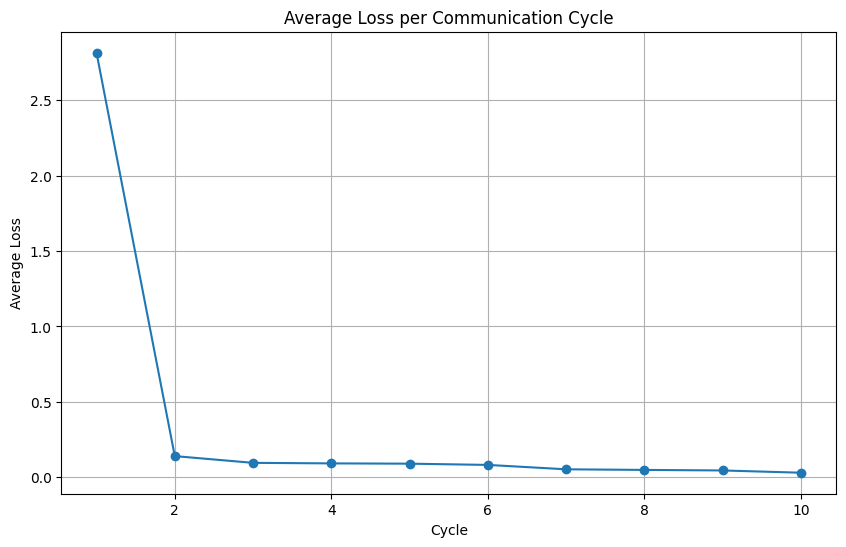

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), all_cycle_losses, marker='o')
plt.title("Average Loss per Communication Cycle")
plt.xlabel("Cycle")
plt.ylabel("Average Loss")
plt.grid(True)
plt.show()



#**TRIALS**

In [ ]:
pip install pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import MinMaxScaler as SparkMinMaxScaler
from pyspark.ml.clustering import KMeans as SparkKMeans
from pyspark.sql.functions import col
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Initialize Spark session
spark = SparkSession.builder.appName("FederatedLearning").getOrCreate()


In [ ]:
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.sql.functions import col

# Load the dataset into a Spark DataFrame
file_path = '/content/drive/MyDrive/output (1).csv'
data = spark.read.csv(file_path, header=True, inferSchema=True)

# Drop unnecessary column
data = data.drop("Unnamed: 0")

# Separate features and label
features = data.drop("Severity")
label = data.select("Severity")

# Normalize the features using Spark's MinMaxScaler
assembler = VectorAssembler(inputCols=features.columns, outputCol="features")
data = assembler.transform(data)

# Normalize the features
scaler_features = MinMaxScaler(inputCol="features", outputCol="normalized_features")
scaler_features_model = scaler_features.fit(data)
data = scaler_features_model.transform(data)

# Convert 'Severity' to a vector column
label_assembler = VectorAssembler(inputCols=["Severity"], outputCol="label_vector")
data = label_assembler.transform(data)

# Normalize the label (Severity)
scaler_labels = MinMaxScaler(inputCol="label_vector", outputCol="normalized_severity")
scaler_labels_model = scaler_labels.fit(data)
data = scaler_labels_model.transform(data)

# Optionally, you can drop the 'label_vector' column since it's no longer needed
data = data.drop("label_vector")

# Show the transformed data
data.show()

In [ ]:
# Step 2: Update the clustering features and apply K-Means clustering
clustering_features = normalized_features[:, [5, 6, 7, 4]]
kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(clustering_features)

# Assign priority levels to each cluster
cluster_priority = {}
for cluster in range(3):
    cluster_data = data[data['Cluster'] == cluster]
    avg_rate = cluster_data['Rate'].mean()
    cluster_priority[cluster] = 'High' if avg_rate > np.percentile(data['Rate'], 66) else 'Low'

# Define processing frequencies
processing_frequency = {'High': 1, 'Low': 3}



In [ ]:
# Apply KMeans clustering
kmeans = SparkKMeans(k=3, seed=42, featuresCol="normalized_features", predictionCol="Cluster")
model = kmeans.fit(data)
data = model.transform(data)

# Assign priority levels to each cluster
cluster_priority = {}
for cluster in range(3):
    cluster_data = data.filter(col("Cluster") == cluster)
    avg_rate = cluster_data.select("Rate").agg({"Rate": "avg"}).collect()[0][0]
    cluster_priority[cluster] = "High" if avg_rate > np.percentile(data.select("Rate").rdd.flatMap(lambda x: x).collect(), 66) else "Low"


In [ ]:
# Apply KMeans clustering
kmeans = SparkKMeans(k=3, seed=42, featuresCol="normalized_features", predictionCol="Cluster")
model = kmeans.fit(data)
data = model.transform(data)

# Assign priority levels to each cluster
cluster_priority = {}
for cluster in range(3):
    # Filter data by cluster
    cluster_data = data.filter(col("Cluster") == cluster)

    # Calculate average rate for the cluster
    avg_rate = cluster_data.select("Rate").agg({"Rate": "avg"}).collect()[0][0]

    # Calculate the 66th percentile for the current cluster's Rate
    percentile_66 = np.percentile([row['Rate'] for row in cluster_data.select("Rate").collect()], 66)

    # Assign priority based on the average rate and percentile within the cluster
    cluster_priority[cluster] = "High" if avg_rate > percentile_66 else "Low"


In [ ]:
# Split the dataset among multiple RSUs
def split_data(data, num_clients=3):
    return data.randomSplit([1.0 / num_clients] * num_clients)

num_clients = 3
rsu_datasets = split_data(data, num_clients=num_clients)


In [ ]:
class RSUModel(nn.Module):
    def __init__(self):
        super(RSUModel, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        return self.fc4(x)


In [ ]:
def train_local_model(rsu_data, model, epochs=5, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Convert Spark DataFrame to pandas for features
    features = rsu_data.select("Rate", "Sender Stopping Distance", "Receiver Stopping Distance", "Actual Distance").toPandas().values

    # Extract the label column ('normalized_severity') as a DenseVector, and convert it to a numpy array
    labels = rsu_data.select("normalized_severity").rdd.flatMap(lambda x: x).collect()
    labels = np.array([label[0] for label in labels])  # Extract the scalar values from the DenseVector

    # Ensure labels are in float32 format
    labels = labels.astype(np.float32).reshape(-1, 1)

    features_tensor = torch.tensor(features, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.float32)

    dataset = TensorDataset(features_tensor, labels_tensor)
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

    for epoch in range(epochs):
        for features_batch, labels_batch in dataloader:
            optimizer.zero_grad()
            predictions = model(features_batch)
            loss = criterion(predictions, labels_batch)
            loss.backward()
            optimizer.step()

    return model.state_dict(), loss.item()


In [ ]:
def federated_averaging(models):
    global_model_state = models[0].copy()
    for key in global_model_state:
        for model_state in models[1:]:
            global_model_state[key] += model_state[key]
        global_model_state[key] /= len(models)
    return global_model_state


In [ ]:
global_model = RSUModel()
rsu_models = [RSUModel() for _ in range(num_clients)]

print("\nFederated Learning Simulation with Multiple RSUs and Processing Frequency")
for cycle in range(10):  # Simulate 10 communication rounds
    print(f"\nCycle {cycle + 1}:")
    local_models = []
    for i, rsu_data in enumerate(rsu_datasets):
        cluster_id = rsu_data.select("Cluster").first()[0]
        priority = cluster_priority[cluster_id]

        # Check if the RSU should be processed in this cycle based on its priority
        if (cycle + 1) % processing_frequency[priority] == 0:
            print(f"  Training RSU {i + 1} (Cluster: {cluster_id}, Priority: {priority})")
            model_state, loss = train_local_model(rsu_data, rsu_models[i], epochs=5)
            local_models.append(model_state)
            print(f"    - RSU {i + 1} Local Training Loss: {loss:.4f}")

    # Perform federated averaging only if models were trained in this cycle
    if local_models:
        global_model_state = federated_averaging(local_models)
        global_model.load_state_dict(global_model_state)

        # Update local models with the new global model
        for rsu_model in rsu_models:
            rsu_model.load_state_dict(global_model_state)

print("\nFederated Learning Completed. Global Model is updated.")


#SAHI WALA CODE

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import MinMaxScaler as SparkMinMaxScaler
from pyspark.ml.clustering import KMeans as SparkKMeans
from pyspark.sql.functions import col
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Initialize Spark session
spark = SparkSession.builder.appName("FederatedLearning").getOrCreate()

from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.sql.functions import col

# Load the dataset into a Spark DataFrame
file_path = '/content/drive/MyDrive/output (1).csv'
data = spark.read.csv(file_path, header=True, inferSchema=True)

# Drop unnecessary column
data = data.drop("Unnamed: 0")

# Separate features and label
features = data.drop("Severity")
label = data.select("Severity")

# Normalize the features using Spark's MinMaxScaler
assembler = VectorAssembler(inputCols=features.columns, outputCol="features")
data = assembler.transform(data)

# Normalize the features
scaler_features = MinMaxScaler(inputCol="features", outputCol="normalized_features")
scaler_features_model = scaler_features.fit(data)
data = scaler_features_model.transform(data)

# Convert 'Severity' to a vector column
label_assembler = VectorAssembler(inputCols=["Severity"], outputCol="label_vector")
data = label_assembler.transform(data)

# Normalize the label (Severity)
scaler_labels = MinMaxScaler(inputCol="label_vector", outputCol="normalized_severity")
scaler_labels_model = scaler_labels.fit(data)
data = scaler_labels_model.transform(data)

# Optionally, you can drop the 'label_vector' column since it's no longer needed
data = data.drop("label_vector")

# Show the transformed data
data.show()


In [ ]:
# Apply KMeans clustering
kmeans = SparkKMeans(k=3, seed=42, featuresCol="normalized_features", predictionCol="Cluster")
model = kmeans.fit(data)
data = model.transform(data)

# Show a sample of the data with clusters to verify the clustering
data.select("Cluster", "Rate").show(10)


In [ ]:
# Apply KMeans clustering
kmeans = SparkKMeans(k=3, seed=42, featuresCol="normalized_features", predictionCol="Cluster")
model = kmeans.fit(data)
data = model.transform(data)

# Assign priority levels to each cluster
cluster_priority = {}
for cluster in range(3):
    # Filter data by cluster
    cluster_data = data.filter(col("Cluster") == cluster)

    # Calculate average rate for the cluster
    avg_rate = cluster_data.select("Rate").agg({"Rate": "avg"}).collect()[0][0]

    # Calculate the 66th percentile for the current cluster's Rate
    percentile_66 = np.percentile([row['Rate'] for row in cluster_data.select("Rate").collect()], 66)

    # Assign priority based on the average rate and percentile within the cluster
    cluster_priority[cluster] = "High" if avg_rate > percentile_66 else "Low"


In [ ]:
# Split the dataset among multiple RSUs
def split_data(data, num_clients=3):
    return data.randomSplit([1.0 / num_clients] * num_clients)

num_clients = 3
rsu_datasets = split_data(data, num_clients=num_clients)


In [ ]:
class RSUModel(nn.Module):
    def __init__(self):
        super(RSUModel, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        return self.fc4(x)


In [ ]:
def train_local_model(rsu_data, model, epochs=5, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Convert Spark DataFrame to pandas for features
    features = rsu_data.select("Rate", "Sender Stopping Distance", "Receiver Stopping Distance", "Actual Distance").toPandas().values

    # Extract the label column ('normalized_severity') as a DenseVector, and convert it to a numpy array
    labels = rsu_data.select("normalized_severity").rdd.flatMap(lambda x: x).collect()
    labels = np.array([label[0] for label in labels])  # Extract the scalar values from the DenseVector

    # Ensure labels are in float32 format
    labels = labels.astype(np.float32).reshape(-1, 1)

    features_tensor = torch.tensor(features, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.float32)

    dataset = TensorDataset(features_tensor, labels_tensor)
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

    for epoch in range(epochs):
        for features_batch, labels_batch in dataloader:
            optimizer.zero_grad()
            predictions = model(features_batch)
            loss = criterion(predictions, labels_batch)
            loss.backward()
            optimizer.step()

    return model.state_dict(), loss.item()


In [ ]:
def federated_averaging(models):
    global_model_state = models[0].copy()
    for key in global_model_state:
        for model_state in models[1:]:
            global_model_state[key] += model_state[key]
        global_model_state[key] /= len(models)
    return global_model_state


In [ ]:
# Federated Learning Loop
for cycle in range(10):  # Simulate 10 communication rounds
    print(f"\nCycle {cycle + 1}:")
    local_models = []

    # Loop over each RSU's data
    for i, rsu_data in enumerate(rsu_datasets):
        cluster_id = rsu_data.select("Cluster").first()[0]
        priority = cluster_priority[cluster_id]  # Get priority from updated logic

        # Check if the RSU should be processed in this cycle based on its priority
        if (cycle + 1) % processing_frequency[priority] == 0:
            print(f"  Training RSU {i + 1} (Cluster: {cluster_id}, Priority: {priority})")
            model_state, loss = train_local_model(rsu_data, rsu_models[i], epochs=5)
            local_models.append(model_state)
            print(f"    - RSU {i + 1} Local Training Loss: {loss:.4f}")

    # Perform federated averaging only if models were trained in this cycle
    if local_models:
        global_model_state = federated_averaging(local_models)
        global_model.load_state_dict(global_model_state)

        # Update local models with the new global model
        for rsu_model in rsu_models:
            rsu_model.load_state_dict(global_model_state)

print("\nFederated Learning Completed. Global Model is updated.")


#FINAL WALA CODE

In [ ]:

# Updated Code 2 with checks and fixes for Cluster 2

from pyspark.sql import SparkSession
from pyspark.ml.feature import MinMaxScaler as SparkMinMaxScaler
from pyspark.ml.clustering import KMeans as SparkKMeans
from pyspark.sql.functions import col
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Initialize Spark session
spark = SparkSession.builder.appName("FederatedLearning").getOrCreate()

from pyspark.ml.feature import VectorAssembler, MinMaxScaler

# Load the dataset into a Spark DataFrame
file_path = '/content/drive/MyDrive/output (1).csv'
data = spark.read.csv(file_path, header=True, inferSchema=True)

# Drop unnecessary column
data = data.drop("Unnamed: 0")

# Separate features and label
features = data.drop("Severity")
label = data.select("Severity")

# Normalize the features using Spark's MinMaxScaler
assembler = VectorAssembler(inputCols=features.columns, outputCol="features")
data = assembler.transform(data)

# Normalize the features
scaler_features = MinMaxScaler(inputCol="features", outputCol="normalized_features")
scaler_features_model = scaler_features.fit(data)
data = scaler_features_model.transform(data)

# Convert 'Severity' to a vector column
label_assembler = VectorAssembler(inputCols=["Severity"], outputCol="label_vector")
data = label_assembler.transform(data)

# Normalize the label (Severity)
scaler_labels = MinMaxScaler(inputCol="label_vector", outputCol="normalized_severity")
scaler_labels_model = scaler_labels.fit(data)
data = scaler_labels_model.transform(data)

# Apply KMeans clustering
kmeans = SparkKMeans(k=3, seed=42, featuresCol="normalized_features", predictionCol="Cluster")
model = kmeans.fit(data)
data = model.transform(data)

# Show the distribution of points across clusters
cluster_counts = data.groupBy("Cluster").count().collect()
print("Cluster distribution:")
for row in cluster_counts:
    print(f"Cluster {row['Cluster']}: {row['count']} points")

# Assign priority levels to each cluster
cluster_priority = {}
for cluster in range(3):
    cluster_data = data.filter(col("Cluster") == cluster)
    avg_rate = cluster_data.select("Rate").agg({"Rate": "avg"}).collect()[0][0]
    percentile_66 = np.percentile(
        [row["Rate"] for row in cluster_data.select("Rate").collect()], 66
    )
    cluster_priority[cluster] = "High" if avg_rate > percentile_66 else "Low"

# Define processing frequencies
processing_frequency = {"High": 1, "Low": 3}

# Split the dataset among multiple RSUs
def split_data(data, num_clients=3):
    return data.randomSplit([1.0 / num_clients] * num_clients)

num_clients = 3
rsu_datasets = split_data(data, num_clients=num_clients)

# Define RSU model
class RSUModel(nn.Module):
    def __init__(self):
        super(RSUModel, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        return self.fc4(x)

# Train RSU locally
def train_local_model(rsu_data, model, epochs=5, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Convert Spark DataFrame to pandas for features
    features = rsu_data.select(
        "Rate", "Sender Stopping Distance", "Receiver Stopping Distance", "Actual Distance"
    ).toPandas().values

    labels = rsu_data.select("normalized_severity").rdd.flatMap(lambda x: x).collect()
    labels = np.array([label[0] for label in labels]).astype(np.float32).reshape(-1, 1)

    features_tensor = torch.tensor(features, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.float32)

    dataset = TensorDataset(features_tensor, labels_tensor)
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

    for epoch in range(epochs):
        for features_batch, labels_batch in dataloader:
            optimizer.zero_grad()
            predictions = model(features_batch)
            loss = criterion(predictions, labels_batch)
            loss.backward()
            optimizer.step()

    return model.state_dict(), loss.item()

# Federated averaging
def federated_averaging(models):
    global_model_state = models[0].copy()
    for key in global_model_state:
        for model_state in models[1:]:
            global_model_state[key] += model_state[key]
        global_model_state[key] /= len(models)
    return global_model_state




# Split the dataset among multiple RSUs, ensuring all clusters are represented
def split_data_by_cluster(data, num_clients=3):
    clusters = data.select("Cluster").distinct().collect()
    cluster_datasets = {}

    for cluster in clusters:
        cluster_id = cluster["Cluster"]
        cluster_datasets[cluster_id] = data.filter(col("Cluster") == cluster_id)

    rsu_datasets = []
    for i in range(num_clients):
        client_data = None
        for cluster_id in cluster_datasets:
            cluster_data = cluster_datasets[cluster_id].sample(
                withReplacement=False, fraction=1.0 / num_clients
            )
            if client_data is None:
                client_data = cluster_data
            else:
                client_data = client_data.union(cluster_data)
        rsu_datasets.append(client_data)

    return rsu_datasets

# Use the new split function
rsu_datasets = split_data_by_cluster(data, num_clients=num_clients)

# Federated Learning Simulation with Fixes
global_model = RSUModel()
rsu_models = [RSUModel() for _ in range(num_clients)]

for cycle in range(10):  # Simulate 10 communication rounds
    print(f"\nCycle {cycle + 1}:")
    local_models = []

    for i, rsu_data in enumerate(rsu_datasets):
        clusters_in_rsu = rsu_data.select("Cluster").distinct().collect()
        for cluster_row in clusters_in_rsu:
            cluster_id = cluster_row["Cluster"]
            priority = cluster_priority[cluster_id]

            # Train only if the cluster's priority matches the cycle frequency
            if (cycle + 1) % processing_frequency[priority] == 0:
                print(f"  Training RSU {i + 1} (Cluster: {cluster_id}, Priority: {priority})")
                model_state, loss = train_local_model(rsu_data, rsu_models[i], epochs=5)
                local_models.append(model_state)
                print(f"    - RSU {i + 1} Local Training Loss: {loss:.4f}")

    if local_models:
        global_model_state = federated_averaging(local_models)
        global_model.load_state_dict(global_model_state)

        for rsu_model in rsu_models:
            rsu_model.load_state_dict(global_model_state)

print("\nFederated Learning Completed. Global Model is updated.")


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import MinMaxScaler as SparkMinMaxScaler
from pyspark.ml.clustering import KMeans as SparkKMeans
from pyspark.sql.functions import col
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder.appName("FederatedLearning").getOrCreate()

from pyspark.ml.feature import VectorAssembler, MinMaxScaler

# Load the dataset into a Spark DataFrame
file_path = '/content/drive/MyDrive/output (1).csv'
data = spark.read.csv(file_path, header=True, inferSchema=True)

# Drop unnecessary column
data = data.drop("Unnamed: 0")

# Separate features and label
features = data.drop("Severity")
label = data.select("Severity")

# Normalize the features using Spark's MinMaxScaler
assembler = VectorAssembler(inputCols=features.columns, outputCol="features")
data = assembler.transform(data)

# Normalize the features
scaler_features = MinMaxScaler(inputCol="features", outputCol="normalized_features")
scaler_features_model = scaler_features.fit(data)
data = scaler_features_model.transform(data)

# Convert 'Severity' to a vector column
label_assembler = VectorAssembler(inputCols=["Severity"], outputCol="label_vector")
data = label_assembler.transform(data)

# Normalize the label (Severity)
scaler_labels = MinMaxScaler(inputCol="label_vector", outputCol="normalized_severity")
scaler_labels_model = scaler_labels.fit(data)
data = scaler_labels_model.transform(data)

# Apply KMeans clustering
kmeans = SparkKMeans(k=3, seed=42, featuresCol="normalized_features", predictionCol="Cluster")
model = kmeans.fit(data)
data = model.transform(data)

# Visualize cluster distribution
cluster_counts = data.groupBy("Cluster").count().collect()
clusters, counts = zip(*[(row["Cluster"], row["count"]) for row in cluster_counts])

plt.figure(figsize=(8, 6))
plt.bar(clusters, counts, color='skyblue')
plt.title("Cluster Distribution")
plt.xlabel("Cluster")
plt.ylabel("Number of Points")
plt.show()

# Assign priority levels to each cluster
cluster_priority = {}
for cluster in range(3):
    cluster_data = data.filter(col("Cluster") == cluster)
    avg_rate = cluster_data.select("Rate").agg({"Rate": "avg"}).collect()[0][0]
    percentile_66 = np.percentile(
        [row["Rate"] for row in cluster_data.select("Rate").collect()], 66
    )
    cluster_priority[cluster] = "High" if avg_rate > percentile_66 else "Low"

# Define processing frequencies
processing_frequency = {"High": 1, "Low": 3}

# Split the dataset among multiple RSUs
def split_data_by_cluster(data, num_clients=3):
    clusters = data.select("Cluster").distinct().collect()
    cluster_datasets = {}

    for cluster in clusters:
        cluster_id = cluster["Cluster"]
        cluster_datasets[cluster_id] = data.filter(col("Cluster") == cluster_id)

    rsu_datasets = []
    for i in range(num_clients):
        client_data = None
        for cluster_id in cluster_datasets:
            cluster_data = cluster_datasets[cluster_id].sample(
                withReplacement=False, fraction=1.0 / num_clients
            )
            if client_data is None:
                client_data = cluster_data
            else:
                client_data = client_data.union(cluster_data)
        rsu_datasets.append(client_data)

    return rsu_datasets

num_clients = 3
rsu_datasets = split_data_by_cluster(data, num_clients=num_clients)

# Define RSU model
class RSUModel(nn.Module):
    def __init__(self):
        super(RSUModel, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        return self.fc4(x)

# Train RSU locally
def train_local_model(rsu_data, model, epochs=5, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Convert Spark DataFrame to pandas for features
    features = rsu_data.select(
        "Rate", "Sender Stopping Distance", "Receiver Stopping Distance", "Actual Distance"
    ).toPandas().values

    labels = rsu_data.select("normalized_severity").rdd.flatMap(lambda x: x).collect()
    labels = np.array([label[0] for label in labels]).astype(np.float32).reshape(-1, 1)

    features_tensor = torch.tensor(features, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.float32)

    dataset = TensorDataset(features_tensor, labels_tensor)
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

    training_losses = []
    for epoch in range(epochs):
        for features_batch, labels_batch in dataloader:
            optimizer.zero_grad()
            predictions = model(features_batch)
            loss = criterion(predictions, labels_batch)
            loss.backward()
            optimizer.step()
        training_losses.append(loss.item())

    return model.state_dict(), training_losses

# Federated averaging
def federated_averaging(models):
    global_model_state = models[0].copy()
    for key in global_model_state:
        for model_state in models[1:]:
            global_model_state[key] += model_state[key]
        global_model_state[key] /= len(models)
    return global_model_state

# Federated Learning Simulation with Visualizations
global_model = RSUModel()
rsu_models = [RSUModel() for _ in range(num_clients)]

all_cycle_losses = []

for cycle in range(10):  # Simulate 10 communication rounds
    print(f"\nCycle {cycle + 1}:")
    local_models = []
    cycle_losses = []

    for i, rsu_data in enumerate(rsu_datasets):
        clusters_in_rsu = rsu_data.select("Cluster").distinct().collect()
        for cluster_row in clusters_in_rsu:
            cluster_id = cluster_row["Cluster"]
            priority = cluster_priority[cluster_id]

            # Train only if the cluster's priority matches the cycle frequency
            if (cycle + 1) % processing_frequency[priority] == 0:
                print(f"  Training RSU {i + 1} (Cluster: {cluster_id}, Priority: {priority})")
                model_state, losses = train_local_model(rsu_data, rsu_models[i], epochs=5)
                local_models.append(model_state)
                cycle_losses.append(np.mean(losses))
                print(f"    - RSU {i + 1} Local Training Loss: {losses[-1]:.4f}")

    all_cycle_losses.append(np.mean(cycle_losses) if cycle_losses else None)

    if local_models:
        global_model_state = federated_averaging(local_models)
        global_model.load_state_dict(global_model_state)

        for rsu_model in rsu_models:
            rsu_model.load_state_dict(global_model_state)

# Plot the average loss per communication cycle
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), all_cycle_losses, marker='o')
plt.title("Average Loss per Communication Cycle")
plt.xlabel("Cycle")
plt.ylabel("Average Loss")
plt.grid(True)
plt.show()

print("\nFederated Learning Completed. Global Model is updated.")
